In [6]:
import os
import mmcv
from mmcv import Config

from mmseg.datasets import build_dataloader, build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import single_gpu_test

from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel

import pandas as pd
import numpy as np
import json

In [7]:
import  torch
print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"

1.6.0


# Train에 대한 Inference & Label Noise EDA

  - Train Set에 Noise가 존재하는 경우가 있을 것이다 가설을 세웠습니다.
  - 특정 class 의 IoU 들을 조사하고 교차하는 IoU 값이 적은 Pred Img를 뽑아내 시각화합니다.
  - Area, Class IoU를 선정할 수 있습니다.

## Config 모델 설정 & Train_all Dataset 설정

  - Train_all Dataset은 해당 Data Tree에 맞도록 구성해줍니다. 

In [8]:
# config file name
config_fileName = "upernet_swin.py"
cfg_root = "/opt/ml/segmentation/mmsegmentation/work_dirs/upernet_swin"

# pth name
model_name = 'swin_plain_Fold_1'

# data path
root='/opt/ml/segmentation/mmsegmentation/data/images_all'

In [9]:
# config file 들고오기
cfg = Config.fromfile(os.path.join(cfg_root, config_fileName))

print(cfg.keys())
# dataset config 수정
cfg.data.test.img_dir = root
cfg.data.test.pipeline[1]['img_scale'] = (512,512) # Resize
cfg.data.test.test_mode = True

cfg.data.samples_per_gpu = 4

cfg.data.test.type = "CustomDataset"

cfg.work_dir = cfg_root #'../output/mmseg/hr48_512x512'

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

# checkpoint path
#checkpoint_path = os.path.join(cfg.work_dir, f'{model_name}.pth')
checkpoint_path = "/opt/ml/segmentation/mmsegmentation/pretrain/swin_plain_Fold_1.pth"

dict_keys(['norm_cfg', 'backbone_norm_cfg', 'model', 'dataset_type', 'data_root', 'CLASSES', 'PALETTE', 'img_norm_cfg', 'train_pipeline', 'test_pipeline', 'Fold', 'data', 'dataset_fold_num', 'log_config', 'dist_params', 'log_level', 'load_from', 'resume_from', 'workflow', 'cudnn_benchmark', 'optimizer', 'optimizer_config', 'lr_config', 'runner', 'checkpoint_config', 'evaluation', 'work_dir', 'gpu_ids'])


In [7]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

2021-11-02 05:53:41,143 - mmseg - INFO - Loaded 3272 images


mmseg
Registry(name=dataset, items={'CustomDataset': <class 'mmseg.datasets.custom.CustomDataset'>, 'ADE20KDataset': <class 'mmseg.datasets.ade.ADE20KDataset'>, 'ChaseDB1Dataset': <class 'mmseg.datasets.chase_db1.ChaseDB1Dataset'>, 'CityscapesDataset': <class 'mmseg.datasets.cityscapes.CityscapesDataset'>, 'DarkZurichDataset': <class 'mmseg.datasets.dark_zurich.DarkZurichDataset'>, 'ConcatDataset': <class 'mmseg.datasets.dataset_wrappers.ConcatDataset'>, 'RepeatDataset': <class 'mmseg.datasets.dataset_wrappers.RepeatDataset'>, 'DRIVEDataset': <class 'mmseg.datasets.drive.DRIVEDataset'>, 'HRFDataset': <class 'mmseg.datasets.hrf.HRFDataset'>, 'NightDrivingDataset': <class 'mmseg.datasets.night_driving.NightDrivingDataset'>, 'PascalContextDataset': <class 'mmseg.datasets.pascal_context.PascalContextDataset'>, 'PascalContextDataset59': <class 'mmseg.datasets.pascal_context.PascalContextDataset59'>, 'STAREDataset': <class 'mmseg.datasets.stare.STAREDataset'>, 'PascalVOCDataset': <class 'mms

In [8]:
model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg'))
model.to(device)
# model = build_segmentor(cfg.model, train_cfg=cfg.get('train_cfg'))

/opt/ml/segmentation/mmsegmentation/mmseg/models/backbones/swin.py:553: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '


EncoderDecoder(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (adap_padding): AdaptivePadding()
      (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (drop_after_pos): Dropout(p=0.0, inplace=False)
    (stages): ModuleList(
      (0): SwinBlockSequence(
        (blocks): ModuleList(
          (0): SwinBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftWindowMSA(
              (w_msa): WindowMSA(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop): DropPath()
            )
            (norm2): LayerNorm((128,), eps=1e-05, el

In [9]:
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

#print(model)

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

Use load_from_local loader


In [10]:
output = single_gpu_test(model, data_loader)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3272/3272, 5.3 task/s, elapsed: 613s, ETA:     0s

## 전체 Train Set에 대한 Inference 진행 후, Submission file을 뽑아냅니다.

In [11]:
# sample_submisson.csv 열기
submission = pd.read_csv('/opt/ml/segmentation/baseline_code/submission/sample_submission.csv', index_col=None)
json_dir = os.path.join("/opt/ml/segmentation/input/data/train_all.json")

with open(json_dir, "r", encoding="utf8") as outfile:
    datas = json.load(outfile)

input_size = 512
output_size = 256
bin_size = input_size // output_size

# PredictionString 대입
for image_id, predict in enumerate(output):
    image_id = datas["images"][image_id]
    file_name = image_id["file_name"]
    
    temp_mask = []
    predict = predict.reshape(1, 512, 512)
    mask = predict.reshape((1, output_size, bin_size, output_size, bin_size)).max(4).max(2) # resize to 256*256
    temp_mask.append(mask)
    oms = np.array(temp_mask)
    oms = oms.reshape([oms.shape[0], output_size*output_size]).astype(int)

    string = oms.flatten()

    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv(os.path.join(cfg.work_dir, f'submission_{model_name}_train_all.csv'), index=False)

## GT와 정렬 후, 이미지별 mIoU 살펴보기

In [1]:
# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors
from tqdm import tqdm
import cv2
import warnings 
warnings.filterwarnings('ignore')

# utils
import pandas as pd
import numpy as np
import json
import torch

plt.rcParams['axes.grid'] = False


In [2]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap
def create_trash_label_colormap():

    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):

    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [10]:
#make_csv
best_output_path = os.path.join(cfg.work_dir, f'submission_{model_name}_train_all.csv')
gt_image_path = os.path.join("/opt/ml/segmentation/input/images_all/img_anno")

pred_df = pd.read_csv(best_output_path)

### Gt Mask plot & Pred Mask plot

3272
0000.png
batch_01_vt/0002.jpg
(256, 256)


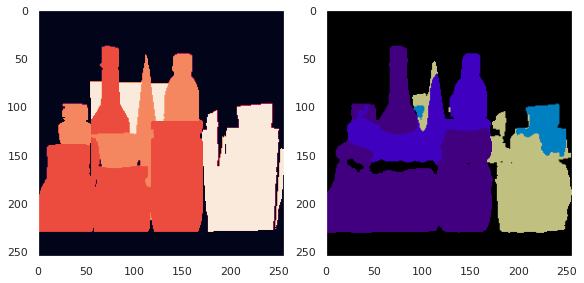

In [11]:
### gt img test
input_size = 512
output_size = 256
bin_size = input_size // output_size

# make gt file list & sort
file_list = [i for i in os.listdir(gt_image_path) if i.endswith('.png')]
file_list = sorted(file_list)
train_size = len(file_list)

print(len(file_list))
print(file_list[0])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4*2, 4*2), constrained_layout=True)

# read gt_img
gt_img = cv2.imread(os.path.join(gt_image_path,file_list[0]))
gt_img = cv2.split(gt_img)

# resize
gt_img = gt_img[0].reshape(1, 512, 512)
mask = gt_img.reshape((1, output_size, bin_size, output_size, bin_size)).max(4).max(2)
mask = mask[0]

ax[0].imshow(mask)

### pred img test
pred_str = pred_df["PredictionString"][0]
pred_id = pred_df["image_id"][0]

pred_cate = list(map(int, set(pred_str.split())))
pred_str_reshape = np.array(list(map(int, pred_str.split()))).reshape(256,256)

ax[1].imshow(label_to_color_image(pred_str_reshape))
print(pred_id)
print(pred_str_reshape.shape)


### Make Image_info

  - Image_id : {gt_img: [] , pred_img: []}

In [12]:

def make_imgInfo(img_info):

    train_size = len(file_list)

    for idx in range(train_size):
        # read gt_img
        gt_img = cv2.imread(os.path.join(gt_image_path,file_list[idx]))
        gt_img = cv2.split(gt_img)
        
        # resize
        gt_img = gt_img[0].reshape(1, 512, 512)
        mask = gt_img.reshape((1, output_size, bin_size, output_size, bin_size)).max(4).max(2)
        mask = mask[0]

        # make predict img
        pred_str = pred_df["PredictionString"][idx]
        pred_id = pred_df["image_id"][idx]

        # make pred img resize
        #pred_cate = list(map(int, set(pred_str.split())))
        pred_str_reshape = np.array(list(map(int, pred_str.split()))).reshape(256,256)

        img_info[pred_id] = {"gt_img": mask, "pred_img": pred_str_reshape}

    return img_info

In [13]:
img_info = dict()
img_info = make_imgInfo(img_info)

## hist matrix를 이용한 IoU 구하기

In [14]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    # print(mask)
    # print(label_true[mask])
    #print(mask.shape)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist

def add_hist(hist, label_trues, label_preds, n_class):
    """
        stack hist(confusion matrix)
    """
    hist = _fast_hist(label_trues.flatten(), label_preds.flatten(), n_class)
    return hist

def label_accuracy_score(hist):
    """
    Returns accuracy score evaluation result.
      - [acc]: overall accuracy
      - [acc_cls]: mean accuracy
      - [mean_iu]: mean IU
      - [fwavacc]: fwavacc
    """
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)

    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)

    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc, iu

In [20]:

# 보고자하는 IoU 면적과 class를 설정
area_thre = 500
IoU_thre = 0.45
class_id = 2

img_info_IoU = dict()
total_mIoU = []
for k, v in img_info.items():
    masks = v["gt_img"]
    outputs = v["pred_img"]
    n_class = []
    class_num = []

    hist = np.zeros((11, 11))
    hist = add_hist(hist, masks, outputs, n_class=11)
    acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
    total_mIoU.append(mIoU)
    
    # 아래의 식에서 다양하게 조절할 수 있습니다.

    for idx in range(1, 11):
        if hist.sum(axis=0)[idx] > 0:
            class_num.append(hist.sum(axis=0)[idx])
        if hist.sum(axis=0)[idx] >= area_thre and IoU[idx] <= IoU_thre and (idx == class_id):
            n_class.append([idx, round(IoU[idx], 4)])

     
    if len(class_num) == 1:
        if n_class:
            v["class"] = n_class
            img_info_IoU.update({k: v})

print(len(img_info_IoU.keys()))

5


## Plot mIoU Graph

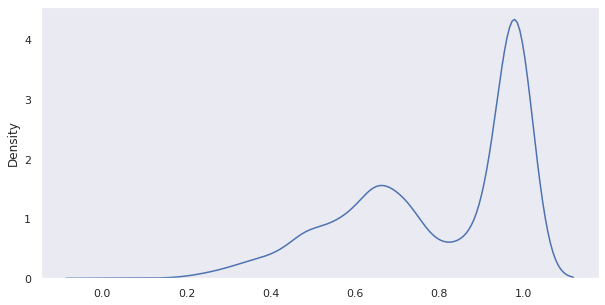

In [21]:
to_graph = sorted(total_mIoU)
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=np.array(to_graph))
plt.show()

## Plot Image

In [22]:
def make_elements(pred_cate):
    # variable for legend
    # pred_class를 나타내는 legend를 만들어 줍니다.
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values) if idx in pred_cate]

    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                                edgecolor=webcolors.rgb_to_hex(rgb), 
                                label=category) for category, rgb in category_and_rgb]

    return legend_elements

In [23]:
helper = 1

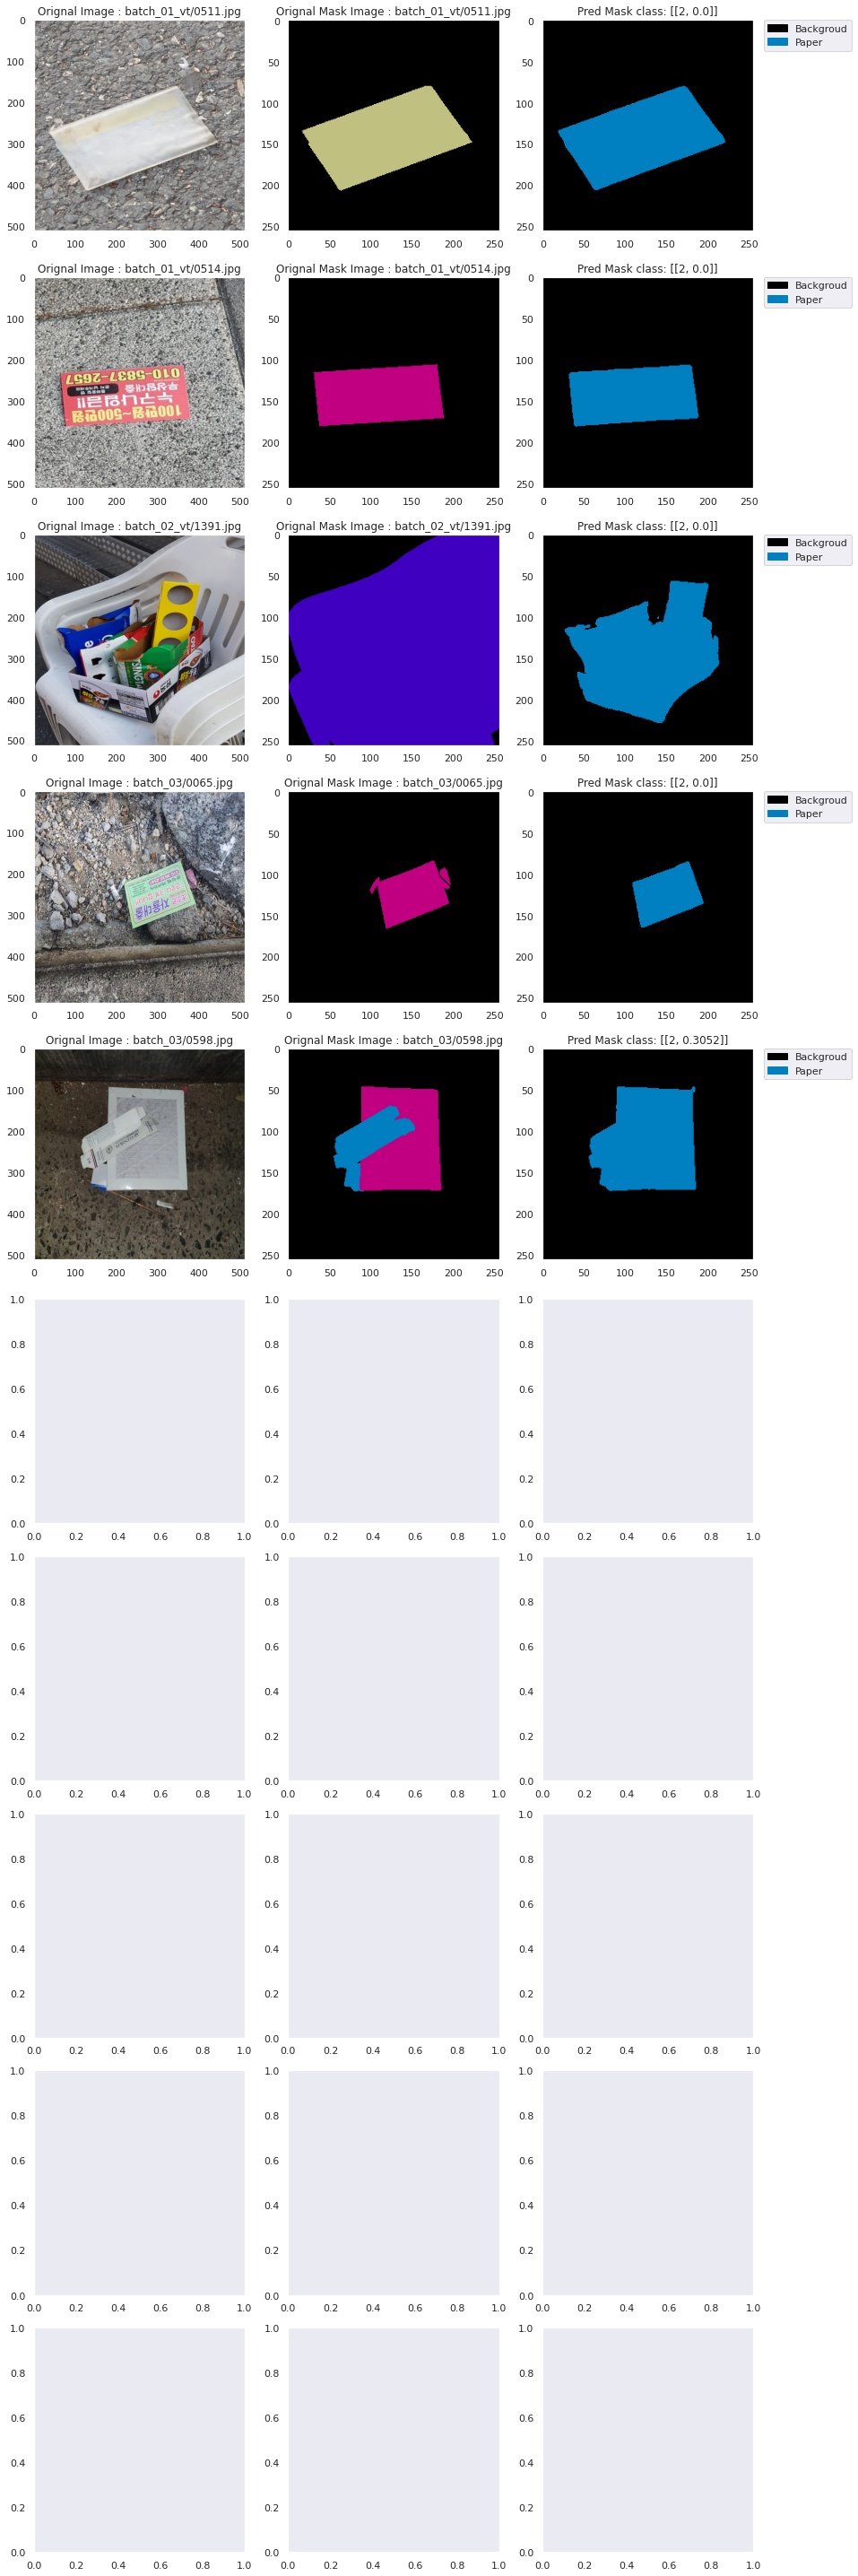

In [24]:
num_examples = 10 #len(list(img_info_mIoU.keys()))# 뽑아낼 image 개수
num_cols = 3 # Original | Prediction

# plot
fig, ax = plt.subplots(nrows=num_examples, ncols=num_cols, figsize=(4*num_cols, 4*num_examples), constrained_layout=True)
fig.tight_layout()

row_num = 0
for idx, (Id, info) in enumerate(img_info_IoU.items()):
    if idx < (helper-1) * num_examples or idx >= helper * num_examples:
        continue
    original_img = cv2.imread(os.path.join("/opt/ml/segmentation/input/data/", Id))
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB).astype(np.int32)
    gt_img = info["gt_img"]
    pred_img_id = info["pred_img"]
    n_class = info["class"]

    # Original Image
    ax[row_num][0].imshow(original_img)
    ax[row_num][0].set_title(f"Orignal Image : {Id}")

    # Original Mask Image
    ax[row_num][1].imshow(label_to_color_image(gt_img))
    ax[row_num][1].set_title(f"Orignal Mask Image : {Id}")
    
    # Pred Mask
    ax[row_num][2].imshow(label_to_color_image(pred_img_id))
    ax[row_num][2].set_title(f"Pred Mask class: {n_class}")

    # Pred Class
    ax[row_num][2].legend(handles=make_elements(pred_img_id), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
    
    row_num += 1
    if idx >= helper * num_examples:
        break
helper += 1